# Run Differential notebook
In this notebook I experimented with models using runs scored and runs against. None of this made it into my final model

In [44]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
pd.options.mode.chained_assignment = None
%config InlineBackend.figure_formats = ['svg']
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [45]:
offensive = ['W', 'G', 'R', 'BA', 'OBP', 'SLG']
against = ['R_A', 'BA_A', 'OBP_A', 'SLG_A']


offensive_avg_features = ['OBP', 'SLG']
opponent_avg_features = ['OBP_A', 'SLG_A']

In [46]:
# create a df of pure stats
offense_df = pd.read_pickle("full_baseball_from_1950_df.pkl")
offense_df = offense_df[["Year", "Team"]+offensive]

In [47]:
# create a df of pure stats for opponents
opponent_df = pd.read_pickle("opponents_from_1950_df.pkl")
opponent_df.rename(columns={'R': 'R_A', 'BA': 'BA_A', 'OBP':'OBP_A', 'SLG': 'SLG_A'}, inplace=True)
opponent_df = opponent_df[["Year", "Team"]+against]

In [48]:
full_df = pd.merge(offense_df, opponent_df, on=["Year", "Team"])
full_df

,Year,Team,W,G,R,BA,OBP,SLG,R_A,BA_A,OBP_A,SLG_A
0,2020,ARI,25,60,4.48,0.241,0.312,0.391,295,0.253,0.336,0.462
1,2019,ARI,85,162,5.02,0.252,0.323,0.434,743,0.251,0.320,0.432
2,2018,ARI,82,162,4.28,0.235,0.310,0.397,644,0.239,0.310,0.388
3,2017,ARI,93,162,5.01,0.254,0.329,0.445,659,0.240,0.309,0.398
4,2016,ARI,69,162,4.64,0.261,0.320,0.432,890,0.275,0.348,0.454
...,...,...,...,...,...,...,...,...,...,...,...,...
1767,1973,WSN,79,162,4.12,0.251,0.340,0.364,702,0.250,0.334,0.371
1768,1972,WSN,70,156,3.29,0.234,0.303,0.325,609,0.245,0.321,0.351
1769,1971,WSN,71,162,3.84,0.246,0.322,0.343,729,0.261,0.341,0.388
1770,1970,WSN,73,162,4.24,0.237,0.323,0.365,807,0.261,0.349,0.407


In [49]:
full_df[['R_A']] =  full_df[['R_A']].div(full_df.G, axis=0)

In [50]:
full_df["RD"] = full_df["R"] - full_df["R_A"]

In [51]:
full_seasons = full_df[full_df["G"]==162]
full_seasons

,Year,Team,W,G,R,BA,OBP,SLG,R_A,BA_A,OBP_A,SLG_A,RD
1,2019,ARI,85,162,5.02,0.252,0.323,0.434,4.586420,0.251,0.320,0.432,0.433580
2,2018,ARI,82,162,4.28,0.235,0.310,0.397,3.975309,0.239,0.310,0.388,0.304691
3,2017,ARI,93,162,5.01,0.254,0.329,0.445,4.067901,0.240,0.309,0.398,0.942099
4,2016,ARI,69,162,4.64,0.261,0.320,0.432,5.493827,0.275,0.348,0.454,-0.853827
5,2015,ARI,79,162,4.44,0.264,0.324,0.414,4.401235,0.258,0.322,0.423,0.038765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,1975,WSN,75,162,3.71,0.244,0.317,0.348,4.259259,0.259,0.339,0.370,-0.549259
1767,1973,WSN,79,162,4.12,0.251,0.340,0.364,4.333333,0.250,0.334,0.371,-0.213333
1769,1971,WSN,71,162,3.84,0.246,0.322,0.343,4.500000,0.261,0.341,0.388,-0.660000
1770,1970,WSN,73,162,4.24,0.237,0.323,0.365,4.981481,0.261,0.349,0.407,-0.741481


# model function

In [52]:
def test_model(features, target):
    """
    Takes a features dataframe and a target data frame as inputs
    Returns the linear model with the score, predicted values etc 
    """
    
    # create the training and validation sets
    features, features_test, target, target_test = train_test_split(features, target, test_size=.2)
    features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=.25)
    
    # set up the model and fir it with training set
    lr = LinearRegression()
    model = lr.fit(features_train, target_train)
    
    # check the score on the validation set
    val_score = lr.score(features_val, target_val)
    print('Validate Score: ', val_score)
    
    # check the score on the validation set
    train_score = lr.score(features_train, target_train)
    print('Train Score: ', train_score)
    
    # run on the hold out test set
    predicted_vals = model.predict(features_test)
    
    data_dict = {
                'Score': val_score,
                'Predicted_Values': predicted_vals,
                'Target_Values': target_test,
                'Coefficients': lr.coef_,
                'Model': model,
                'Intercept' : lr.intercept_
                }
    
    
    return(data_dict)

# Runs Model

In [58]:
p = PolynomialFeatures(degree=3)
features_poly = p.fit_transform(full_seasons[offensive_avg_features])
features = full_seasons[offensive_avg_features]
#features["OBP_DEV"] = (features["OBP"]**2)/(features["OBP"].mean())
#features["SLG_DEV"] = (features["SLG"]**2)/(features["SLG"].mean())
# features["OBPS"] = (features["OBP"] + features["SLG"]) **2

In [59]:
runs_model = test_model(features, full_seasons["R"])

Validate Score:  0.9180739815309107
Train Score:  0.9231372915999982


In [12]:
runs_model['Coefficients']

array([17.10924177,  9.65643296])

In [13]:
"""
for c in zip(offensive_avg_features ,runs_model['Coefficients']):
    print(c[0], c[1])
    
print("Intercept: ", runs_model['Intercept'])

""";

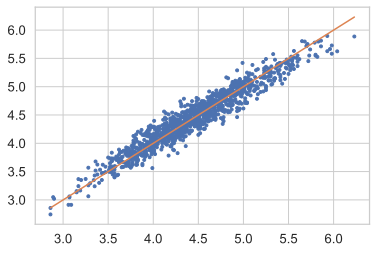

In [14]:
plt.plot(full_seasons["R"], runs_model["Model"].predict(features), '.')
plt.plot(full_seasons[["R"]], full_seasons[["R"]]);

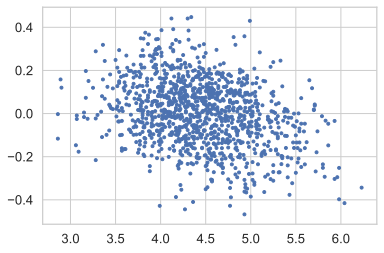

In [15]:
plt.plot( full_seasons["R"], runs_model["Model"].predict(features)-full_seasons["R"], '.');

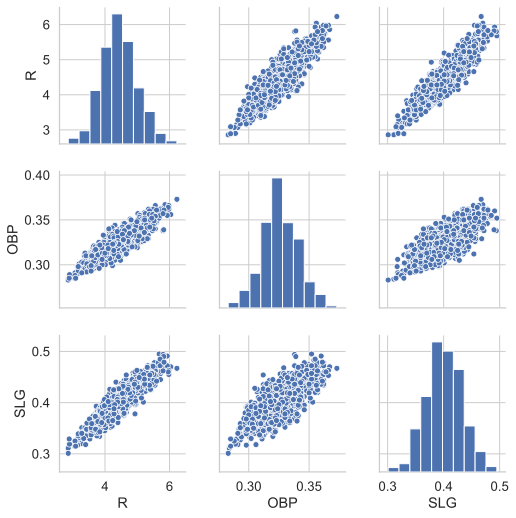

In [19]:
sns.pairplot(full_seasons[["R", "OBP", "SLG"]]);

# Runs Against Model

In [56]:
runs_against_model = test_model(full_seasons[opponent_avg_features], full_seasons["R_A"])

Validate Score:  0.9083218609593854
Train Score:  0.9179990534694951


In [57]:
runs_against_model["Score"]

0.9083218609593854

In [45]:
for c in zip(opponent_avg_features ,runs_against_model['Coefficients']):
    print(c[0], c[1])
    
print("Intercept: ", runs_against_model['Intercept'])

OBP_A 16.97368368376634
SLG_A 9.516621340509474
Intercept:  -4.904008243138051


# Run Differential Model

In [20]:
run_diff_model = test_model(full_seasons[["RD"]], full_seasons["W"]);

Validate Score:  0.878716640472675
Train Score:  0.8763073445048465


In [21]:
run_diff_model["Score"]

0.878716640472675

In [22]:
print("RD: ", run_diff_model['Coefficients'][0])
    
print("Intercept: ", run_diff_model['Intercept'])

RD:  16.432721588836397
Intercept:  81.09823710706796


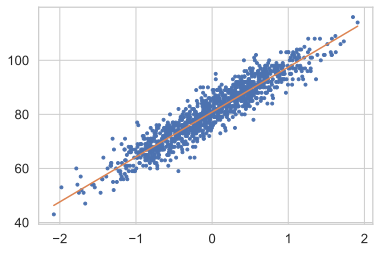

In [23]:
plt.plot(full_seasons[["RD"]], full_seasons["W"], '.')
plt.plot(full_seasons[["RD"]], full_seasons[["RD"]]*16.62+80.87)

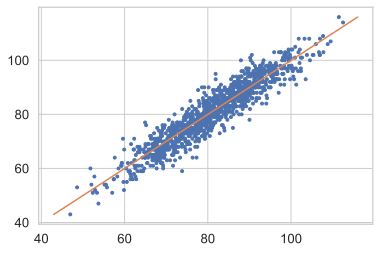

In [24]:
plt.plot(run_diff_model["Model"].predict(full_seasons[["RD"]]), full_seasons["W"], '.')
plt.plot(full_seasons[["W"]], full_seasons[["W"]]);

In [25]:
lr = LinearRegression()
model = lr.fit(run_diff_model["Model"].predict(full_seasons[["RD"]]).reshape(-1, 1), full_seasons["W"])
lr.coef_

array([1.00468611])

# combined

In [34]:
# offensive_features_poly = p.fit_transform(full_seasons[offensive_avg_features])
# opponent_features_poly = p.fit_transform(full_seasons[opponent_avg_features])

predicted_run_diff = runs_model["Model"].predict(full_seasons[offensive_avg_features]) - runs_model["Model"].predict(full_seasons[opponent_avg_features]) 

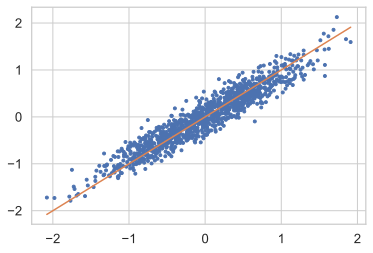

In [35]:

plt.plot(full_seasons["RD"], predicted_run_diff, '.')
plt.plot(full_seasons[["RD"]], full_seasons[["RD"]]);

In [36]:
lr = LinearRegression()
model = lr.fit(full_seasons["RD"].values.reshape(-1, 1), predicted_run_diff)
lr.coef_

array([0.88467833])

In [37]:
# predicted_wins_engineered = run_diff_model["Model"].predict((np.array(predicted_run_diff)*1.2).reshape(-1, 1))
predicted_wins = run_diff_model["Model"].predict((np.array(predicted_run_diff)).reshape(-1, 1))

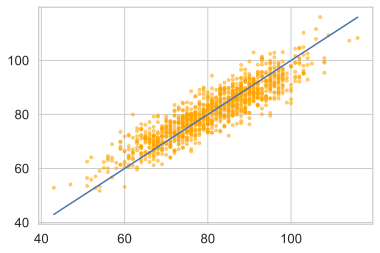

In [38]:
# plt.plot(full_seasons["W"], predicted_wins_engineered, '.', color="red", alpha=.5);
plt.plot(full_seasons["W"], predicted_wins, '.', color="orange", alpha=.5);
plt.plot(full_seasons["W"],full_seasons["W"]);

In [39]:
lr = LinearRegression()
model = lr.fit(full_seasons["W"].values.reshape(-1, 1), predicted_wins)
lr.coef_

array([0.78529262])

In [40]:
"""
lr = LinearRegression()
model = lr.fit(full_seasons["W"].values.reshape(-1, 1), predicted_wins_engineered)
lr.coef_
""";

In [43]:
win_diff = run_diff_model["Predicted_Values"] - run_diff_model["Target_Values"]
win_diff.abs().describe()

TypeError: 'LinearRegression' object is not subscriptable

In [627]:
"""
win_diff_engineered = predicted_wins_engineered - full_seasons["W"]
win_diff_engineered.abs().describe()
""";

In [628]:
winning_df = win_df[win_df["Wins"]>80]
losing_df = win_df[win_df["Wins"]<80]

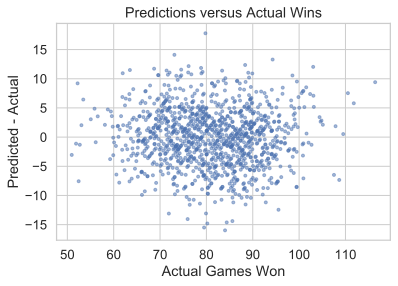

In [634]:
plt.title('Predictions versus Actual Wins')
plt.xticks()
plt.xlabel('Actual Games Won')
plt.ylabel('Predicted - Actual')
# plt.plot(full_seasons["W"], win_diff_engineered, '.', color="orange",)
plt.plot(predicted_wins, win_diff, '.', alpha=0.5);

In [630]:
full_seasons["Diff"] = win_diff

In [633]:
full_seasons.sort_values(by=["Diff"])

,Year,Team,W,G,R,BA,OBP,SLG,R_A,BA_A,OBP_A,SLG_A,RD,Diff
742,2008,ANA,100,162,4.72,0.268,0.330,0.413,4.302469,0.261,0.323,0.406,0.417531,-15.977436
1555,1987,STL,95,162,4.93,0.263,0.340,0.378,4.277778,0.266,0.331,0.404,0.652222,-15.496713
1620,2016,TEX,95,162,4.72,0.262,0.322,0.433,4.672840,0.260,0.329,0.424,0.047160,-14.799550
425,1973,CIN,99,162,4.57,0.254,0.332,0.383,3.833333,0.252,0.318,0.387,0.736667,-14.614722
1063,1969,NYM,100,162,3.90,0.242,0.311,0.351,3.339506,0.227,0.296,0.349,0.560494,-14.390589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,1986,PIT,64,162,4.09,0.250,0.321,0.374,4.320988,0.255,0.327,0.393,-0.230988,12.160218
70,1973,ATL,76,162,4.93,0.266,0.339,0.427,4.777778,0.263,0.332,0.392,0.152222,12.357924
1249,1984,PHI,81,162,4.44,0.266,0.333,0.407,4.259259,0.253,0.308,0.368,0.180741,13.289553
1039,1993,NYM,59,162,4.15,0.248,0.305,0.390,4.592593,0.269,0.324,0.404,-0.442593,14.097734


# Find Score

In [ ]:
offensive_avg_features = ['OBP', 'SLG']
opponent_avg_features = ['OBP_A', 'SLG_A']

In [55]:
features, features_test, target, target_test = train_test_split(full_seasons, full_seasons['W'], test_size=.2)
features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=.25)

In [63]:
run_diff = runs_model["Model"].predict(features_train[offensive_avg_features]) - runs_against_model["Model"].predict(features_train[opponent_avg_features])
win_prediction = run_diff_model["Model"].predict(run_diff.reshape(-1, 1))

In [ ]:
win_diff = win_prediction - target_train